# RadQG Demo
In this notebook, we will demonstrate the main functionalities of the RadQG project in a notebook environment. To work with the GUI application, please run the `app.py` file.

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import skimage.io as io
import radqg.configs as configs
from radqg.generator import Generator
from radqg.llm.openai import embed_fn as openai_embed_fn
from radqg.llm.openai import qa as openai_qa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extracting the figures and text from HTML files 

Please download your desired articles from the RadioGraphics website as HTML files and put them in the toy_data_dir folder. Do not change the names of the files and folders when saving them from the website. Five sample articles are already provided.

In [3]:
# Listing all the HTML files

toy_data_dir = configs.TOY_DATA_DIR

print("Name of the articles: \n")
for file in os.listdir(toy_data_dir):
    if file.endswith(".html"):
        print(file)

Name of the articles: 

Peritoneal and Retroperitoneal Anatomy and Its Relevance for Cross-Sectional Imaging _ RadioGraphics.html
Gastrointestinal Tract Dilatations_ Why and How They Happen—A Simplified Imaging Classification _ RadioGraphics.html
Cross-sectional Imaging of the Duodenum_ Spectrum of Disease _ RadioGraphics.html
Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics.html
Role of Multimodality Imaging in Gastroesophageal Reflux Disease and Its Complications, with Clinical and Pathologic Correlation _ RadioGraphics.html
Imaging of Drug-induced Complications in the Gastrointestinal System _ RadioGraphics.html
Murphy’s Law_ What Can Go Wrong in the Gallbladder_ Resident and Fellow Education Feature _ RadioGraphics.html
Pearls and Pitfalls in Multimodality Imaging of Colonic Volvulus _ RadioGraphics.html
CT Findings of Acute Small-Bowel Entities _ RadioGraphics.html
Surgical Approach to Gastroesophageal Reflux Disease_ Wh

### Create a QA generator

Creating the QA generator is the first step in the pipeline. In addition to the path to the directory containing the HTML files, we need to specify an embedding function (e.g., from OpenAI), and the chunk_size and chunk_overlap values that should be used for splitting the articles into chunks. The latter two could be changed in the notebook or in the `config.py` file.

The next step is to setup the generator. This step will return all the article names, paths to figures detected for the articles, their captions, and also a Python sampler for selecting random figures as the source for question generation. The user can specify a word or phrase as the interested `topic` when setting up the question bank for the generator. If provided, then the QA generator will be more inclined to select figures as the source for question genenration that have haptions related to the topic. Otherwise, the generator will pick completely random figures for question generation.

In [4]:
# Setting up the generator

generator = Generator(
    data_dir=toy_data_dir,
    embed_fn=openai_embed_fn,
    chunk_size=configs.CHUNK_SIZE,
    chunk_overlap=configs.CHUNK_OVERLAP,
)

topic = None
article_names, figpaths, captions, sampler = generator.setup_qbank(topic)

The collection "20231122_111035" has been created with:
    228 figures from 10 articles


### Figure selection
The next step is selecting a random figure. When the figure is selected, the name of the article containing the figure, the path to the figure, and the caption of the figure will be returned.

In [17]:
article_name, figpath, caption = generator.select_figure(
    article_names, figpaths, captions, sampler, reset_memory=False
)
print("Article name: ", article_name)
print("Figure path: ", figpath)
print("Caption: ", caption)

Article name:  CT Findings of Acute Small-Bowel Entities _ RadioGraphics.html
Figure path:  /research/projects/m221279_Pouria/RadQG/data/html_articles/CT Findings of Acute Small-Bowel Entities _ RadioGraphics_files/images_medium_rg.2018170148.fig8.gif
Caption:  Figure 8.Lupus vasculitis in a 43-year-old woman with a history of SLE who presented with severe abdominal pain. Axial oral and intravenous contrast-enhanced CT image shows dilated loops of small bowel with diffuse symmetric wall thickening and mucosal hyperenhancement. Note the corkscrew appearance of the terminal vessels (arrows), a feature of small-vessel ischemic disease related to the underlying vasculitis.


#### Generate a question

The final step is to generate the question. The user should specify a question/answering function (e.g., from OpenAI), the name of the article containing the figure, and the caption of the figure. The question/answering function will return a Python dictionary containing the question and an answer to the questio. Optionally, the generator could also return a subset of the article text (referred to as `context`) that was extracted from the article and the LLM used it for developing a better question from the figure.
> Note: The type_of_question could be one of ["MCQ", "Short-Answer", "Long-Answer"].

fignum: fig8

---------Round 1---------

Radiologist output: {
    "question": "A 43-year-old woman with a history of SLE presents with severe abdominal pain. The CT image shows dilated loops of small bowel with diffuse symmetric wall thickening and mucosal hyperenhancement. The terminal vessels have a corkscrew appearance. What is the most likely underlying cause of these imaging findings?",
    "options": {
        "A": "Polyarteritis nodosa",
        "B": "Henoch-Schönlein purpura",
        "C": "Microscopic polyangiitis",
        "D": "Lupus vasculitis",
        "E": "Raynaud's phenomenon"
    },
    "answer": "Lupus vasculitis is the most likely underlying cause. The patient's history of SLE, the corkscrew appearance of the terminal vessels, and the other imaging findings are all consistent with this diagnosis."
}
Educationist output: {"Status": "Fail", "Message": "The sentence 'The CT image shows dilated loops of small bowel with diffuse symmetric wall thickening and mucosal hype

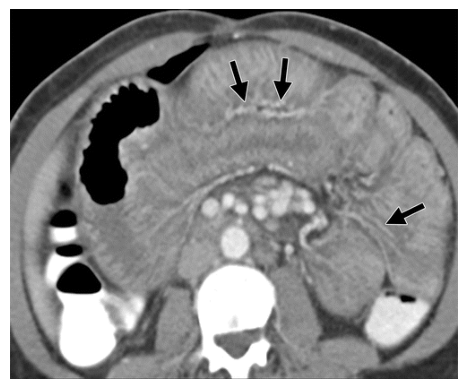

In [18]:
qa_json, *logs = generator.generate_qa(
    qa_fn=openai_qa,
    article_name=article_name,
    figpath=figpath,
    caption=caption,
    type_of_question="MCQ",
    complete_return=True,
)

figure = io.imread(figpath).squeeze()
plt.imshow(figure)
plt.axis("off")
print(f"Question: {qa_json['question']}")
if "options" in qa_json:
    for choice, option in zip(["A", "B", "C", "D", "E"], qa_json["options"]):
        print(f"{choice}) {qa_json['options'][option]}")
print(f"Answer: {qa_json['answer']}")